In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
import re
import datetime
import dateutil
from efunds import EFund
import collections as coll
import statsmodels.api as sm
%matplotlib inline

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# load data

start= datetime.datetime(1900, 1,1)
end= datetime.datetime(2018, 1,1)

d1= pd.read_excel('FF_Research.xlsx', sheet_name= 'FF_5Factors', skiprows=3)
d1.columns= ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
d1['Date']= [datetime.datetime(int(x/100), int(x%100), 1)+dateutil.relativedelta.relativedelta(day=31) for x in d1['Date']]
d1.set_index(keys='Date', inplace=True)

d2= pd.read_excel('FF_Research.xlsx', sheet_name='FF_MOM', skiprows=13)
d2.columns= ['Date','MOM']
d2['Date']= [datetime.datetime(int(x/100), int(x%100), 1)+dateutil.relativedelta.relativedelta(day=31) for x in d2['Date']]
d2.set_index(keys='Date', inplace=True)

d3= pd.read_excel('FF_Research.xlsx', sheet_name='FF_5IndustryVW', skiprows=11)
d3.columns= ['Date','Cnsmr', 'Manuf', 'HiTec', 'Hlth', 'Other']
d3['Date']= [datetime.datetime(int(x/100), int(x%100), 1)+dateutil.relativedelta.relativedelta(day=31) for x in d3['Date']]
d3.set_index(keys='Date', inplace=True)


d4= pd.read_excel('FF_Research.xlsx', sheet_name='FF_12IndustryVW', skiprows=11)
d4.columns= ['Date','NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']
d4['Date']= [datetime.datetime(int(x/100), int(x%100), 1)+dateutil.relativedelta.relativedelta(day=31) for x in d4['Date']]
d4.set_index(keys='Date', inplace=True)


FF_6Factor= pd.concat([d1, d2], axis=1)
FF_6Factor= FF_6Factor.loc[np.logical_and(FF_6Factor.index> start, FF_6Factor.index< end), ].dropna(how='any', axis=0)/100
FF_5Industry= d3.loc[np.logical_and(d3.index> start, d3.index< end), ].dropna(how='any', axis=0)/100
FF_12Industry= d4.loc[np.logical_and(d3.index> start, d3.index< end), ].dropna(how='any', axis=0)/100

pickle.dump(FF_6Factor, open('FF_6Factor.p', 'wb'))
pickle.dump(FF_5Industry, open('FF_5Industry.p', 'wb'))
pickle.dump(FF_12Industry, open('FF_12Industry.p', 'wb'))

INDX_raw= pickle.load(open('INDX_raw.p', 'rb'))
INDX= {}
for k,v in INDX_raw.items():
    a= v[v.index>= datetime.datetime(1900,12,1)]
    r= (a- a.shift(1))/a.shift(1)
    INDX[k]= EFund(ret= r, EProdID= k)
    
INDX_Ret= pd.concat([v.validRet for k, v in INDX.items()], axis=1)
INDX_Ret['Value_Prem']= INDX_Ret['RU1000VTR']- INDX_Ret['RU1000TR']

In [3]:
a= pd.concat([FF_6Factor, INDX_Ret[['RU1000TR', 'Value_Prem']]], axis=1).dropna(how='any', axis=0)
a.corr()
# Note: VP has high corr with HML and CMA

Mkt-RF       SMB       HML       RMW       CMA        RF  \
Mkt-RF      1.000000  0.207553 -0.277677 -0.315909 -0.389499 -0.066817   
SMB         0.207553  1.000000 -0.136178 -0.420110 -0.061348 -0.068020   
HML        -0.277677 -0.136178  1.000000  0.234274  0.690558  0.077292   
RMW        -0.315909 -0.420110  0.234274  1.000000  0.129660  0.028770   
CMA        -0.389499 -0.061348  0.690558  0.129660  1.000000  0.053552   
RF         -0.066817 -0.068020  0.077292  0.028770  0.053552  1.000000   
MOM        -0.128337  0.020697 -0.208497  0.110000 -0.004209  0.065501   
RU1000TR    0.992247  0.119366 -0.242446 -0.260505 -0.368542  0.004591   
Value_Prem -0.312320 -0.150148  0.836289  0.323625  0.657321  0.037703   

                 MOM  RU1000TR  Value_Prem  
Mkt-RF     -0.128337  0.992247   -0.312320  
SMB         0.020697  0.119366   -0.150148  
HML        -0.208497 -0.242446    0.836289  
RMW         0.110000 -0.260505    0.323625  
CMA        -0.004209 -0.368542    0.657321  
RF          0.065501  0.004591    0.037703  
MOM         1.000000 -0.141817   -0.247802  
RU1000TR   -0.141817  1.000000   -0.277524  
Value_Prem -0.247802 -0.277524    1.000000

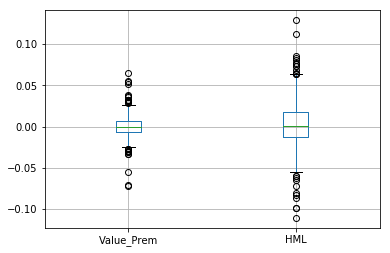

In [4]:
a[['Value_Prem', 'HML',]].boxplot()

In [5]:
b= pd.concat([FF_5Industry, INDX_Ret[['RU1000TR','Value_Prem']]], axis =1).dropna(how='any', axis=0)
b.corr()
b

Cnsmr   Manuf   HiTec    Hlth   Other  RU1000TR  Value_Prem
1980-01-31  0.0421  0.0904  0.0407 -0.0129  0.0550  0.061391   -0.012191
1980-02-29 -0.0526  0.0374 -0.0287 -0.0463 -0.0333  0.001925   -0.001651
1980-03-31 -0.0844 -0.1381 -0.0933 -0.0284 -0.1224 -0.112845    0.008335
1980-04-30  0.0308  0.0616  0.0307  0.0428  0.0605  0.048956    0.005337
1980-05-31  0.0766  0.0498  0.0489  0.0696  0.0811  0.058896    0.009314
1980-06-30  0.0275  0.0425  0.0169  0.0021  0.0516  0.035026   -0.009720
1980-07-31  0.0971  0.0486  0.1020  0.0889  0.0664  0.066250   -0.016975
1980-08-31  0.0161  0.0218  0.0456  0.0030  0.0267  0.017672   -0.002622
1980-09-30  0.0069  0.0426  0.0079  0.0360  0.0364  0.029381   -0.017254
1980-10-31 -0.0085  0.0409  0.0023 -0.0129  0.0156  0.020513   -0.013250
1980-11-30  0.0263  0.1598  0.0667  0.0881  0.0738  0.107115   -0.024216
1980-12-31 -0.0034 -0.0656 -0.0063  0.0461 -0.0072 -0.036550    0.011572
1981-01-31  0.0032 -0.0618 -0.0428 -0.0157 -0.0256 -0.044260    0.030216
1981-02-28  0.0370  0.0132  0.0100  0.0185  0.0171  0.017382    0.001831
1981-03-31  0.0864  0.0165  0.0383  0.0587  0.0845  0.040482    0.004362
1981-04-30  0.0189 -0.0397  0.0197  0.0300  0.0093 -0.017340    0.015061
1981-05-31  0.0273 -0.0156  0.0514  0.0347  0.0252  0.008792   -0.001315
1981-06-30 -0.0177  0.0187 -0.0516 -0.0558 -0.0097 -0.009024    0.014946
1981-07-31 -0.0210  0.0265 -0.0245 -0.0389 -0.0269  0.000374   -0.008733
1981-08-31 -0.0592 -0.0572 -0.0515 -0.0775 -0.0549 -0.054991    0.010098
1981-09-30 -0.0289 -0.0914 -0.0162 -0.0133 -0.0546 -0.060764    0.009693
1981-10-31  0.0414  0.0658  0.0546  0.0795  0.0715  0.057741   -0.021430
1981-11-30  0.0268  0.0569  0.0193  0.0393  0.0508  0.047151    0.005094
1981-12-31 -0.0135 -0.0385 -0.0053 -0.0075 -0.0374 -0.029110    0.002300
1982-01-31 -0.0002 -0.0506  0.0203  0.0145 -0.0325 -0.024887    0.000730
1982-02-28 -0.0180 -0.0694 -0.0539 -0.0180 -0.0392 -0.050978    0.013104
1982-03-31  0.0333 -0.0179 -0.0163 -0.0258 -0.0130 -0.008894    0.011369
1982-04-30  0.0570  0.0375  0.0471  0.0734  0.0371  0.041094   -0.011258
1982-05-31 -0.0268 -0.0111 -0.0398 -0.0305 -0.0547 -0.027021    0.010079
1982-06-30  0.0236 -0.0404 -0.0240 -0.0073 -0.0243 -0.022921   -0.001392
...            ...     ...     ...     ...     ...       ...         ...
2015-07-31  0.0420 -0.0329  0.0225  0.0366  0.0202  0.019275   -0.014890
2015-08-31 -0.0500 -0.0474 -0.0643 -0.0837 -0.0617 -0.060153    0.000596
2015-09-30 -0.0151 -0.0396 -0.0171 -0.0728 -0.0307 -0.027408   -0.002783
2015-10-31  0.0543  0.0869  0.0985  0.0774  0.0650  0.080908   -0.005456
2015-11-30  0.0029 -0.0008  0.0055  0.0071  0.0120  0.003303    0.000524
2015-12-31  0.0013 -0.0466 -0.0265  0.0040 -0.0268 -0.017990   -0.003515
2016-01-31 -0.0330 -0.0346 -0.0503 -0.0942 -0.0823 -0.053824    0.002152
2016-02-29  0.0051  0.0140 -0.0052 -0.0107 -0.0006 -0.000343    0.000091
2016-03-31  0.0581  0.0810  0.0786  0.0292  0.0706  0.069661    0.002374
2016-04-30 -0.0013  0.0349 -0.0305  0.0356  0.0233  0.005439    0.015568
2016-05-31  0.0074 -0.0018  0.0408  0.0247  0.0093  0.017512   -0.001979
2016-06-30  0.0173  0.0264 -0.0091  0.0013 -0.0270  0.002264    0.006383
2016-07-31  0.0246  0.0121  0.0666  0.0602  0.0353  0.038094   -0.009059
2016-08-31 -0.0100  0.0037  0.0073 -0.0322  0.0338  0.001329    0.006382
2016-09-30 -0.0144  0.0105  0.0206  0.0037 -0.0124  0.000792   -0.002876
2016-10-31 -0.0252 -0.0230 -0.0146 -0.0743  0.0061 -0.019500    0.004023
2016-11-30  0.0153  0.0530  0.0166  0.0138  0.1131  0.039423    0.017691
2016-12-31  0.0133  0.0156  0.0160  0.0085  0.0294  0.018787    0.006205
2017-01-31  0.0137  0.0069  0.0437  0.0221  0.0097  0.020108   -0.012985
2017-02-28  0.0299  0.0225  0.0394  0.0707  0.0375  0.038708   -0.002774
2017-03-31  0.0078 -0.0019  0.0190 -0.0016 -0.0168  0.000632   -0.010818
2017-04-30  0.0181  0.0031  0.0224  0.0111  0.0023  0.010572   -0.012449
2017-05-31  0.0200  0.0032  0.0305 -0.0044 -0.0043  0.012762   -0.01374

### FF Industry/Sector Alpha


                            OLS Regression Results                            
Dep. Variable:                  Cnsmr   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1770.
Date:                Tue, 27 Feb 2018   Prob (F-statistic):          9.19e-159
Time:                        10:55:47   Log-Likelihood:                 1152.6
No. Observations:                 456   AIC:                            -2301.
Df Residuals:                     454   BIC:                            -2293.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.791      0.0

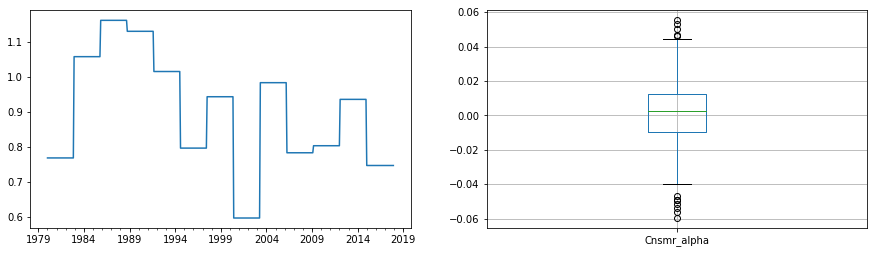

In [6]:
IndAlpha= {}

# Cnsmr
ind= 'Cnsmr'
d= sm.add_constant(b[[ind, 'RU1000TR']])

rollRegs= {}
window_length= 12*3
start= d.index[0]
end = start+ dateutil.relativedelta.relativedelta(months= window_length-1, day= 31)
while end<= d.index[-1]: 
    tmp= d.loc[np.logical_and(d.index>= start, d.index<= end),:]
    y= tmp[ind]
    X= tmp.drop(labels= [ind], axis=1)
    # s= start.strftime('%Y%m%d')+'_'+end.strftime('%Y%m%d')
    rollRegs[start]= sm.OLS(endog=y, exog=X).fit()
    
#     start= start+ dateutil.relativedelta.relativedelta(months= 1, day= 31)
#     end= end+dateutil.relativedelta.relativedelta(months=1, day=31)
    start= end
    end = start+ dateutil.relativedelta.relativedelta(months= window_length-1, day= 31)

rollRegs_df= pd.DataFrame({k:v.params for k,v in rollRegs.items()}).T
rollRegs_df.columns= rollRegs_df.columns+'_beta'
tmp= pd.concat([d, rollRegs_df], axis= 1).fillna(method= 'ffill')
tmp[ind+'_alpha']= tmp[ind]- tmp['RU1000TR']* tmp['RU1000TR_beta']
IndAlpha[ind]= tmp

# rollRegs_df.plot()

plt.figure(figsize=(15,4))
ax= plt.subplot(121)
tmp['RU1000TR_beta'].plot(ax=ax)
ax=plt.subplot(122)
tmp[[ind+'_alpha']].boxplot(ax=ax)
print(sm.OLS(endog=d[ind], exog= d.drop(labels=[ind], axis=1)).fit().summary())
print(tmp[ind+'_alpha'].describe())


                            OLS Regression Results                            
Dep. Variable:                  Manuf   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     1704.
Date:                Tue, 27 Feb 2018   Prob (F-statistic):          8.70e-156
Time:                        10:55:48   Log-Likelihood:                 1144.0
No. Observations:                 456   AIC:                            -2284.
Df Residuals:                     454   BIC:                            -2276.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.370      0.1

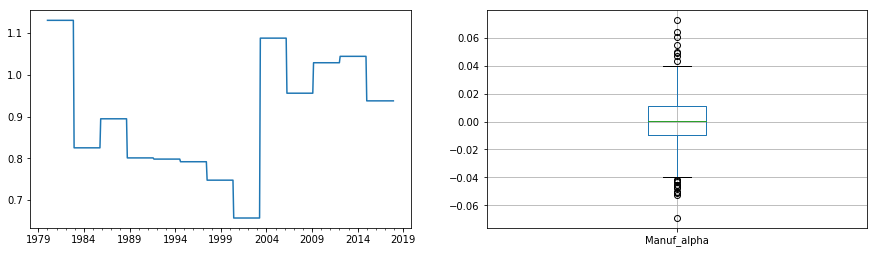

In [7]:

# Manuf
ind= 'Manuf'
d= sm.add_constant(b[[ind, 'RU1000TR']])

rollRegs= {}
window_length= 12*3
start= d.index[0]
end = start+ dateutil.relativedelta.relativedelta(months= window_length-1, day= 31)
while end<= d.index[-1]: 
    tmp= d.loc[np.logical_and(d.index>= start, d.index<= end),:]
    y= tmp[ind]
    X= tmp.drop(labels= [ind], axis=1)
    # s= start.strftime('%Y%m%d')+'_'+end.strftime('%Y%m%d')
    rollRegs[start]= sm.OLS(endog=y, exog=X).fit()
    
#     start= start+ dateutil.relativedelta.relativedelta(months= 1, day= 31)
#     end= end+dateutil.relativedelta.relativedelta(months=1, day=31)
    start= end
    end = start+ dateutil.relativedelta.relativedelta(months= window_length-1, day= 31)

rollRegs_df= pd.DataFrame({k:v.params for k,v in rollRegs.items()}).T
rollRegs_df.columns= rollRegs_df.columns+'_beta'
tmp= pd.concat([d, rollRegs_df], axis= 1).fillna(method= 'ffill')
tmp[ind+'_alpha']= tmp[ind]- tmp['RU1000TR']* tmp['RU1000TR_beta']
IndAlpha[ind]= tmp

# rollRegs_df.plot()

plt.figure(figsize=(15,4))
ax= plt.subplot(121)
tmp['RU1000TR_beta'].plot(ax=ax)
ax=plt.subplot(122)
tmp[[ind+'_alpha']].boxplot(ax=ax)
print(sm.OLS(endog=d[ind], exog= d.drop(labels=[ind], axis=1)).fit().summary())
print(tmp[ind+'_alpha'].describe())


                            OLS Regression Results                            
Dep. Variable:                   Hlth   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     591.1
Date:                Tue, 27 Feb 2018   Prob (F-statistic):           3.17e-84
Time:                        10:55:48   Log-Likelihood:                 948.29
No. Observations:                 456   AIC:                            -1893.
Df Residuals:                     454   BIC:                            -1884.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.466      0.0

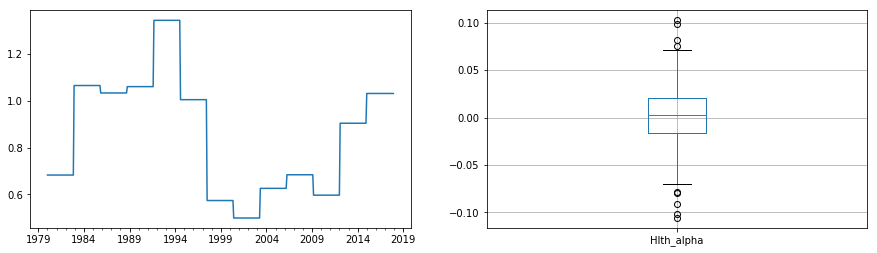

In [8]:

# Hlth
ind= 'Hlth'
d= sm.add_constant(b[[ind, 'RU1000TR']])

rollRegs= {}
window_length= 12*3
start= d.index[0]
end = start+ dateutil.relativedelta.relativedelta(months= window_length-1, day= 31)
while end<= d.index[-1]: 
    tmp= d.loc[np.logical_and(d.index>= start, d.index<= end),:]
    y= tmp[ind]
    X= tmp.drop(labels= [ind], axis=1)
    # s= start.strftime('%Y%m%d')+'_'+end.strftime('%Y%m%d')
    rollRegs[start]= sm.OLS(endog=y, exog=X).fit()
    
#     start= start+ dateutil.relativedelta.relativedelta(months= 1, day= 31)
#     end= end+dateutil.relativedelta.relativedelta(months=1, day=31)
    start= end
    end = start+ dateutil.relativedelta.relativedelta(months= window_length-1, day= 31)

rollRegs_df= pd.DataFrame({k:v.params for k,v in rollRegs.items()}).T
rollRegs_df.columns= rollRegs_df.columns+'_beta'
tmp= pd.concat([d, rollRegs_df], axis= 1).fillna(method= 'ffill')
tmp[ind+'_alpha']= tmp[ind]- tmp['RU1000TR']* tmp['RU1000TR_beta']
IndAlpha[ind]= tmp

# rollRegs_df.plot()

plt.figure(figsize=(15,4))
ax= plt.subplot(121)
tmp['RU1000TR_beta'].plot(ax=ax)
ax=plt.subplot(122)
tmp[[ind+'_alpha']].boxplot(ax=ax)
print(sm.OLS(endog=d[ind], exog= d.drop(labels=[ind], axis=1)).fit().summary())
print(tmp[ind+'_alpha'].describe())


                            OLS Regression Results                            
Dep. Variable:                  HiTec   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     1519.
Date:                Tue, 27 Feb 2018   Prob (F-statistic):          5.97e-147
Time:                        10:55:49   Log-Likelihood:                 988.21
No. Observations:                 456   AIC:                            -1972.
Df Residuals:                     454   BIC:                            -1964.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -0.969      0.3

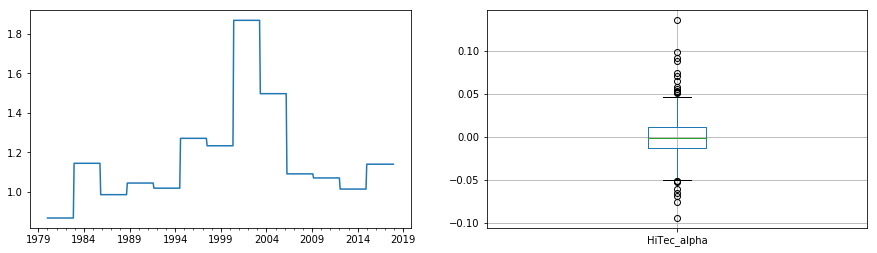

In [9]:

# HiTec
ind= 'HiTec'
d= sm.add_constant(b[[ind, 'RU1000TR']])

rollRegs= {}
window_length= 12*3
start= d.index[0]
end = start+ dateutil.relativedelta.relativedelta(months= window_length-1, day= 31)
while end<= d.index[-1]: 
    tmp= d.loc[np.logical_and(d.index>= start, d.index<= end),:]
    y= tmp[ind]
    X= tmp.drop(labels= [ind], axis=1)
    # s= start.strftime('%Y%m%d')+'_'+end.strftime('%Y%m%d')
    rollRegs[start]= sm.OLS(endog=y, exog=X).fit()
    
#     start= start+ dateutil.relativedelta.relativedelta(months= 1, day= 31)
#     end= end+dateutil.relativedelta.relativedelta(months=1, day=31)
    start= end
    end = start+ dateutil.relativedelta.relativedelta(months= window_length-1, day= 31)

rollRegs_df= pd.DataFrame({k:v.params for k,v in rollRegs.items()}).T
rollRegs_df.columns= rollRegs_df.columns+'_beta'
tmp= pd.concat([d, rollRegs_df], axis= 1).fillna(method= 'ffill')
tmp[ind+'_alpha']= tmp[ind]- tmp['RU1000TR']* tmp['RU1000TR_beta']
IndAlpha[ind]= tmp

# rollRegs_df.plot()

plt.figure(figsize=(15,4))
ax= plt.subplot(121)
tmp['RU1000TR_beta'].plot(ax=ax)
ax=plt.subplot(122)
tmp[[ind+'_alpha']].boxplot(ax=ax)
print(sm.OLS(endog=d[ind], exog= d.drop(labels=[ind], axis=1)).fit().summary())
print(tmp[ind+'_alpha'].describe())


                            OLS Regression Results                            
Dep. Variable:                  Other   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     2524.
Date:                Tue, 27 Feb 2018   Prob (F-statistic):          1.53e-187
Time:                        10:55:49   Log-Likelihood:                 1138.0
No. Observations:                 456   AIC:                            -2272.
Df Residuals:                     454   BIC:                            -2264.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.739      0.4

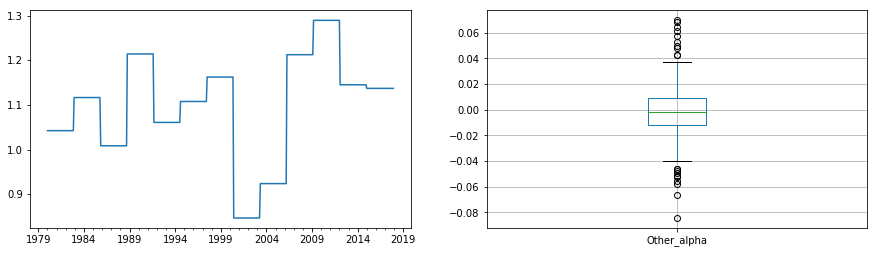

In [10]:

# Other
ind= 'Other'
d= sm.add_constant(b[[ind, 'RU1000TR']])

rollRegs= {}
window_length= 12*3
start= d.index[0]
end = start+ dateutil.relativedelta.relativedelta(months= window_length-1, day= 31)
while end<= d.index[-1]: 
    tmp= d.loc[np.logical_and(d.index>= start, d.index<= end),:]
    y= tmp[ind]
    X= tmp.drop(labels= [ind], axis=1)
    # s= start.strftime('%Y%m%d')+'_'+end.strftime('%Y%m%d')
    rollRegs[start]= sm.OLS(endog=y, exog=X).fit()
    
#     start= start+ dateutil.relativedelta.relativedelta(months= 1, day= 31)
#     end= end+dateutil.relativedelta.relativedelta(months=1, day=31)
    start= end
    end = start+ dateutil.relativedelta.relativedelta(months= window_length-1, day= 31)

rollRegs_df= pd.DataFrame({k:v.params for k,v in rollRegs.items()}).T
rollRegs_df.columns= rollRegs_df.columns+'_beta'
tmp= pd.concat([d, rollRegs_df], axis= 1).fillna(method= 'ffill')
tmp[ind+'_alpha']= tmp[ind]- tmp['RU1000TR']* tmp['RU1000TR_beta']
IndAlpha[ind]= tmp

# rollRegs_df.plot()

plt.figure(figsize=(15,4))
ax= plt.subplot(121)
tmp['RU1000TR_beta'].plot(ax=ax)
ax=plt.subplot(122)
tmp[[ind+'_alpha']].boxplot(ax=ax)
print(sm.OLS(endog=d[ind], exog= d.drop(labels=[ind], axis=1)).fit().summary())
print(tmp[ind+'_alpha'].describe())


In [11]:
tmp= []
tmp2= []
for k,v in IndAlpha.items():
    tmp.append(v[k+'_alpha'])
    t= v['RU1000TR_beta']
    t.name= k+'_beta'
    tmp2.append(t)
FF_5IndustryAlpha= pd.concat(tmp, axis=1)
FF_5IndustryBeta= pd.concat(tmp2, axis=1)

In [12]:
FF_5IndustryAlpha.corr()

Cnsmr_alpha  Manuf_alpha  Hlth_alpha  HiTec_alpha  Other_alpha
Cnsmr_alpha     1.000000    -0.219479    0.111321    -0.192629     0.237837
Manuf_alpha    -0.219479     1.000000   -0.262439    -0.447806    -0.104619
Hlth_alpha      0.111321    -0.262439    1.000000    -0.168299    -0.047574
HiTec_alpha    -0.192629    -0.447806   -0.168299     1.000000    -0.434641
Other_alpha     0.237837    -0.104619   -0.047574    -0.434641     1.000000

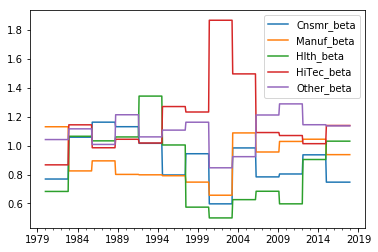

In [13]:
FF_5IndustryBeta.plot()

In [15]:
pickle.dump(FF_5IndustryAlpha, open('FF_5IndustryAlpha.p', 'wb'))
pickle.dump(FF_5IndustryBeta, open( 'FF_5IndustryBeta.p',  'wb'))